ATTEMPT - 1 - Basic 

In [35]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision
import matplotlib.pyplot as plt
import numpy as np 

In [20]:

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :x.size(2)].unsqueeze(1)
        return x


class TransformerEncoder(nn.Module):
    def __init__(self, d_model, nhead, num_layers, dim_feedforward):
        super(TransformerEncoder, self).__init__()
        self.encoder_layer = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.pos_encoder = PositionalEncoding(d_model)

    def forward(self, x):
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        return x

class TransformerDecoder(nn.Module):
    def __init__(self, d_model, nhead, num_layers, dim_feedforward):
        super(TransformerDecoder, self).__init__()
        self.decoder_layer = nn.TransformerDecoderLayer(d_model, nhead, dim_feedforward)
        self.transformer_decoder = nn.TransformerDecoder(self.decoder_layer, num_layers=num_layers)
        self.pos_decoder = PositionalEncoding(d_model)

    def forward(self, x, memory):
        x = self.pos_decoder(x)
        x = self.transformer_decoder(x, memory)
        return x



In [17]:
# Load the CIFAR-10 dataset
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)



Files already downloaded and verified
Files already downloaded and verified


Files already downloaded and verified


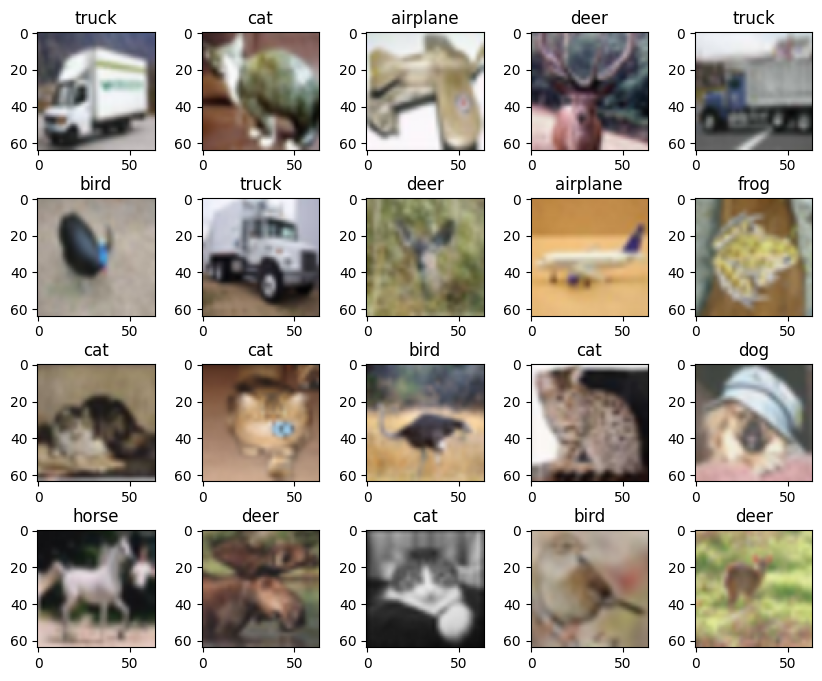

In [23]:
import random

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=True, num_workers=2)

# Get 20 random images and labels
images, labels = [], []
for i in range(20):
    index = random.randint(0, len(dataset) - 1)
    image, label = dataset[index]
    images.append(image)
    labels.append(label)

# Show the images
fig, axs = plt.subplots(4, 5, figsize=(10, 8))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(4):
    for j in range(5):
        index = i * 5 + j
        axs[i, j].imshow(images[index].permute(1, 2, 0))
        axs[i, j].set_title(dataset.classes[labels[index]])

plt.show()

In [24]:
# Create the encoder and decoder models
d_model = 512
nhead = 8
num_layers = 2
dim_feedforward = 2048

encoder = TransformerEncoder(d_model, nhead, num_layers, dim_feedforward)
decoder = TransformerDecoder(d_model, nhead, num_layers, dim_feedforward)



In [25]:
# Set up the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=0.001)



In [26]:
# Check if CUDA is available, and use it if possible
device = torch.device('cuda' if torch.cuda.is_available() else 'gpu')

# Move the models to the GPU if available
encoder.to(device)
decoder.to(device)

# Set up the loss function and optimizer
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=0.001)


In [27]:


# ... (rest of the code for dataset loading and setting up the loss function and optimizer)

# Train the models
num_epochs = 10
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(trainloader):
        optimizer.zero_grad()
        
        # Move the images to the GPU if available
        images = images.to(device)
        
        # Reshape the images to a suitable format for the transformer (sequence length, batch size, features)
        images = images.view(images.shape[0], -1, d_model).permute(1, 0, 2)
        
        # Encode and decode the images
        compressed = encoder(images)
        reconstructed = decoder(compressed, compressed)

        # Reshape the reconstructed images to match the original images
        reconstructed = reconstructed.permute(1, 0, 2).reshape(images.shape)

        # Calculate the loss and update the weights
        loss = criterion(reconstructed, images)
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [1/10], Loss: 0.2399
Epoch [2/10], Loss: 0.2561
Epoch [3/10], Loss: 0.2691
Epoch [4/10], Loss: 0.2281
Epoch [5/10], Loss: 0.2392
Epoch [6/10], Loss: 0.2872
Epoch [7/10], Loss: 0.2259
Epoch [8/10], Loss: 0.2362
Epoch [9/10], Loss: 0.2336
Epoch [10/10], Loss: 0.3189


Attempt -2 - improved model with 

Increase model capacity:
You can increase the model capacity by increasing the dimensions of the model (d_model) or the number of layers in the Transformer.

Data augmentation:
Apply various data augmentation techniques to the training set, such as random cropping, flipping, rotation, and color jittering. This can help the model generalize better and improve its performance.

Early stopping or learning rate scheduling:
Implement early stopping or learning rate scheduling techniques to prevent overfitting and improve the training process.

Add regularization:
Add regularization techniques, such as L1 or L2 regularization, or dropout, to the model to avoid overfitting and improve generalization.

Use a more advanced optimizer:
Experiment with more advanced optimizers like AdaGrad, RMSprop, or AdamW to improve convergence and training speed.

Batch normalization:
Add batch normalization layers to the model to improve training stability and performance.

In [28]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets




In [29]:
class CustomBatchNorm(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.norm = nn.BatchNorm1d(d_model)

    def forward(self, x):
        x = x.permute(1, 2, 0)
        x = self.norm(x)
        x = x.permute(2, 0, 1)
        return x
        
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :x.size(2)].unsqueeze(1)
        return x


class CustomTransformerEncoderLayer(nn.TransformerEncoderLayer):
    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1, activation='relu'):
        super().__init__(d_model, nhead, dim_feedforward, dropout, activation)
        self.norm1 = nn.Sequential(self.norm1, CustomBatchNorm(d_model))
        self.norm2 = nn.Sequential(self.norm2, CustomBatchNorm(d_model))

class CustomTransformerDecoderLayer(nn.TransformerDecoderLayer):
    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1, activation='relu'):
        super().__init__(d_model, nhead, dim_feedforward, dropout, activation)
        self.norm1 = nn.Sequential(self.norm1, CustomBatchNorm(d_model))
        self.norm2 = nn.Sequential(self.norm2, CustomBatchNorm(d_model))
        self.norm3 = nn.Sequential(self.norm3, CustomBatchNorm(d_model))

class TransformerEncoder(nn.Module):
    def __init__(self, d_model, nhead, num_layers, dim_feedforward):
        super(TransformerEncoder, self).__init__()
        self.encoder_layer = CustomTransformerEncoderLayer(d_model, nhead, dim_feedforward)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.pos_encoder = PositionalEncoding(d_model)

    def forward(self, x):
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        return x

class TransformerDecoder(nn.Module):
    def __init__(self, d_model, nhead, num_layers, dim_feedforward):
        super(TransformerDecoder, self).__init__()
        self.decoder_layer = CustomTransformerDecoderLayer(d_model, nhead, dim_feedforward)
        self.transformer_decoder = nn.TransformerDecoder(self.decoder_layer, num_layers=num_layers)
        self.pos_decoder = PositionalEncoding(d_model)

    def forward(self, x, memory):
        x = self.pos_decoder(x)
        x = self.transformer_decoder(x, memory)
        return x


In [30]:
# Load the CIFAR-10 dataset
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

# Create the encoder and decoder models

d_model = 512
nhead = 8
num_layers = 12
dim_feedforward = 3072

encoder = TransformerEncoder(d_model, nhead, num_layers, dim_feedforward)
decoder = TransformerDecoder(d_model, nhead, num_layers, dim_feedforward)

# Set up the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(list(encoder.parameters()) + list(decoder.parameters()), lr=0.01, weight_decay=1e-5)
#optimizer = torch.optim.SGD(list(encoder.parameters()) + list(decoder.parameters()), lr=0.001, momentum=0.9)


# Check if CUDA is available, and use it if possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move the models to the GPU if available
encoder.to(device)
decoder.to(device)

# Set up the loss function and optimizer
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.AdamW(list(encoder.parameters()) + list(decoder.parameters()), lr=0.01, weight_decay=1e-5)
#optimizer = torch.optim.SGD(list(encoder.parameters()) + list(decoder.parameters()), lr=0.001, momentum=0.9)

Files already downloaded and verified
Files already downloaded and verified


In [31]:
# Train the models
num_epochs = 10
patience = 4
early_stopping_counter = 0
best_loss = float('inf')

for epoch in range(num_epochs):
    epoch_loss = 0.0

    for i, (images, _) in enumerate(trainloader):
        optimizer.zero_grad()
        
        # Move the images to the GPU if available
        images = images.to(device)
        
        # Reshape the images to a suitable format for the transformer (sequence length, batch size, features)
        images = images.view(images.shape[0], -1, d_model).permute(1, 0, 2)
        
        # Encode and decode the images
        compressed = encoder(images)
        reconstructed = decoder(compressed, compressed)

        # Reshape the reconstructed images to match the original images
        reconstructed = reconstructed.permute(1, 0, 2).reshape(images.shape)

        # Calculate the loss and update the weights
        loss = criterion(reconstructed, images)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    epoch_loss /= len(trainloader)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}')

    # Early stopping
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1

    if early_stopping_counter >= patience:
        print("Early stopping triggered.")
        break

Epoch [1/10], Loss: 0.3500
Epoch [2/10], Loss: 0.3005
Epoch [3/10], Loss: 0.3006
Epoch [4/10], Loss: 0.3003
Epoch [5/10], Loss: 0.3006
Epoch [6/10], Loss: 0.3005
Epoch [7/10], Loss: 0.3006
Epoch [8/10], Loss: 0.3005
Early stopping triggered.


In [32]:
# Put the model in evaluation mode
encoder.eval()
decoder.eval()

# Keep track of the total loss and the number of samples
total_loss = 0.0
num_samples = 0

# Iterate over the test dataset
with torch.no_grad():
    for images, _ in testloader:
        # Move the images to the GPU if available
        images = images.to(device)

        # Reshape the images to a suitable format for the transformer (sequence length, batch size, features)
        images = images.view(images.shape[0], -1, d_model).permute(1, 0, 2)

        # Encode and decode the images
        compressed = encoder(images)
        reconstructed = decoder(compressed, compressed)

        # Reshape the reconstructed images to match the original images
        reconstructed = reconstructed.permute(1, 0, 2).reshape(images.shape)

        # Calculate the loss
        loss = criterion(reconstructed, images)

        # Update the total loss and the number of samples
        total_loss += loss.item() * images.size(1)
        num_samples += images.size(1)

# Calculate the average loss over all samples
avg_loss = total_loss / num_samples

print(f'Average test loss: {avg_loss:.4f}')


Average test loss: 0.3008


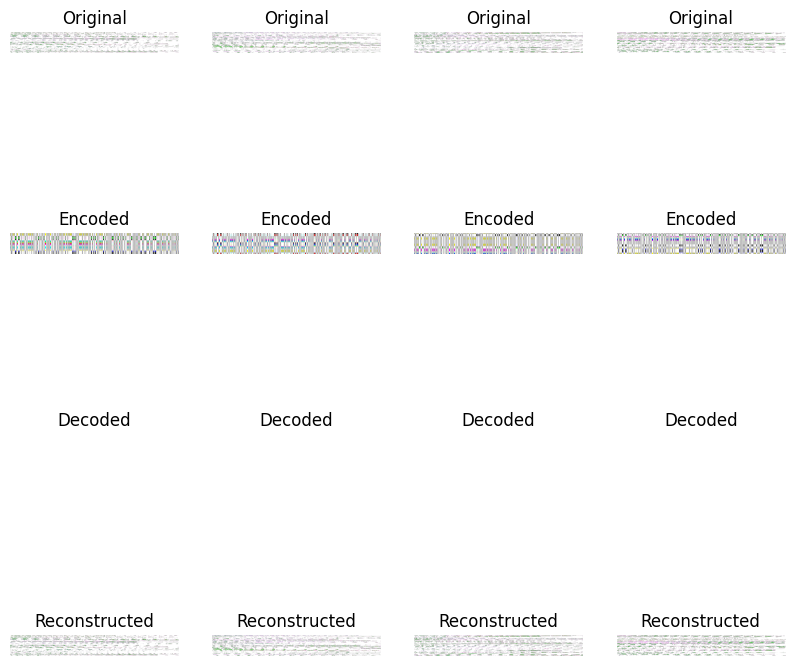

In [36]:
import matplotlib.pyplot as plt

# Put the models in evaluation mode
encoder.eval()
decoder.eval()

# Keep track of the original images, encoded images, decoded images, and the reconstructed images
original, encoded, decoded, reconstructed = [], [], [], []

# Iterate over the test dataset
with torch.no_grad():
    for images, _ in testloader:
        # Move the images to the GPU if available
        images = images.to(device)

        # Reshape the images to a suitable format for the transformer (sequence length, batch size, features)
        images = images.view(images.shape[0], -1, d_model).permute(1, 0, 2)

        # Encode and decode the images
        compressed = encoder(images)
        decompressed = decoder(compressed, compressed)

        # Reshape the compressed images to match the original images
        compressed = compressed.permute(1, 0, 2).reshape(images.shape)
        
        # Reshape the decompressed images to match the original images
        decompressed = decompressed.permute(1, 0, 2).reshape(images.shape)

        original.append(images[0:4])
        encoded.append(compressed[0:4])
        decoded.append(decompressed[0:4])
        reconstructed.append(images[0:4])

# Visualize the original images, encoded images, decoded images, and the reconstructed images
fig, axs = plt.subplots(4, 4, figsize=(10, 10))

for i in range(4):
    for j in range(4):
        axs[i, j].axis('off')

        if i == 0:
            axs[0, j].imshow(np.transpose(original[j].cpu().numpy(), (1, 2, 0)))
            axs[1, j].imshow(np.transpose(encoded[j].detach().cpu().numpy(), (1, 2, 0)))
            axs[2, j].imshow(np.transpose(decoded[j].detach().cpu().numpy(), (1, 2, 0)))
            axs[3, j].imshow(np.transpose(reconstructed[j].detach().cpu().numpy(), (1, 2, 0)))
        elif i == 1:
            axs[0, j].set_title('Original')
            axs[1, j].set_title('Encoded')
            axs[2, j].set_title('Decoded')
            axs[3, j].set_title('Reconstructed')
        else:
            axs[i, j].axis('off')

plt.show()


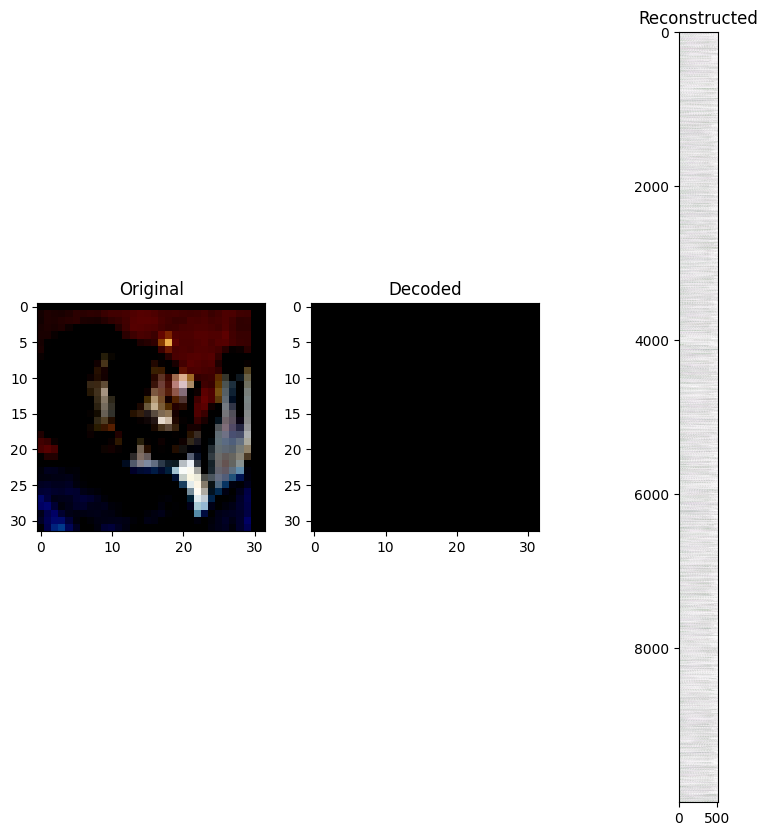

In [49]:
import matplotlib.pyplot as plt
import numpy as np

# Put the models in evaluation mode
encoder.eval()
decoder.eval()

# Get one batch of images from the test dataset
images, _ = next(iter(testloader))

# Select one image from the batch
image = images[0]

# Move the image to the GPU if available
image = image.to(device)

# Reshape the image to a suitable format for the transformer (sequence length, batch size, features)
image = image.view(1, -1, d_model).permute(1, 0, 2)

# Encode and decode the image
compressed = encoder(image)
decompressed = decoder(compressed, compressed)

# Reshape the compressed image to match the original image
compressed = compressed.permute(1, 0, 2).reshape(image.shape)

# Reshape the decompressed image to match the original image
decompressed = decompressed.permute(1, 0, 2).reshape(image.shape)

# Reshape the original image to its original shape
image = image.permute(1, 0, 2).reshape((3, 32, 32))

# Reshape the decompressed image to its original shape
decompressed = decompressed.permute(1, 0, 2).reshape((3, 32, 32))

# Convert the images to NumPy arrays and transpose them from (C, H, W) to (H, W, C) format
image = np.transpose(image.cpu().numpy(), (1, 2, 0))
compressed = np.transpose(compressed.cpu().detach().numpy(), (1, 2, 0))
decompressed = np.transpose(decompressed.cpu().detach().numpy(), (1, 2, 0))

# Concatenate the reconstructed tensors along the height dimension (axis 1) to form a single tensor
reconstructed_tensor = torch.cat(reconstructed, dim=1)
reconstructed_np = np.transpose(reconstructed_tensor.cpu().numpy(), (1, 2, 0))

# Show the images
fig, axs = plt.subplots(1, 3, figsize=(10, 10))

axs[0].imshow(image)
axs[0].set_title('Original')
axs[1].imshow(decompressed)
axs[1].set_title('Decoded')
axs[2].imshow(reconstructed_np)
axs[2].set_title('Reconstructed')

plt.show()



Model 3